In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import dataframe_image as dfi
import seaborn as sns

In [3]:
import datetime as dt
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
station=Base.classes.station
measurement=Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

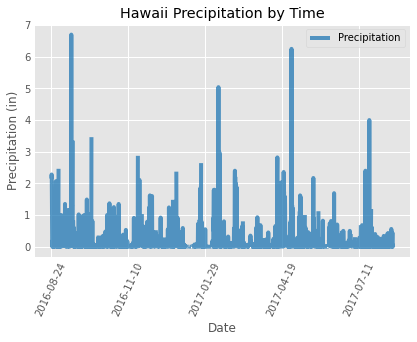

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
for i in last_date:
    date_time_obj = dt.date.fromisoformat(i)

year_ago =  dt.date(date_time_obj.year,date_time_obj.month,date_time_obj.day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp=session.query(measurement).\
    filter(measurement.date > str(year_ago)).all()


d={'Date':[],'Precipitation':[]}
for i in prcp:
    d['Date'].append(i.date)
    d['Precipitation'].append(i.prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(d,index=d['Date'],columns=['Precipitation'])

# Sort the dataframe by date
sorted_df=df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('ggplot')
sorted_df.plot.line(color='tab:blue',alpha=0.75)
plt.xlabel('Date')
plt.xticks(rotation=65)
plt.ylabel('Precipitation (in)')
plt.title("Hawaii Precipitation by Time")
plt.savefig('img/precip.png',bbox_inches='tight')

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_stats=sorted_df.describe()
dfi.export(prcp_stats,'img/prcp_stats.png')
prcp_stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(measurement.station).distinct().count()
station_count

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count=func.count(measurement.station).label('station_count')

station_activity=session.query(measurement.station, station_count)\
.group_by(measurement.station).order_by(station_count.desc()).all()

d={'Station':[],'# of Rows':[]}
for i in station_activity:
    d['Station'].append(i.station)
    d['# of Rows'].append(i.station_count)

station_df=pd.DataFrame(d)
dfi.export(station_df,'img/station_count.png')
station_df

,Station,# of Rows
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_min=func.min(measurement.tobs).label('station_min')
station_max=func.max(measurement.tobs).label('station_max')
station_mean=func.avg(measurement.tobs).label('station_mean')

busy_station=session.query(measurement.station, station_min,station_max,station_mean)\
.filter(measurement.station=='USC00519281').all()
    
d={'Most Active Station':[],'Lowest Temp (F)':[],'Highest Temp (F)':[],'Average Temp (F)':[]}
for i in busy_station:
    d['Most Active Station'].append(i.station)
    d['Lowest Temp (F)'].append(i.station_min)
    d['Highest Temp (F)'].append(i.station_max)
    d['Average Temp (F)'].append(i.station_mean)

active_df=pd.DataFrame(d)
dfi.export(active_df,'img/active_station.png')
active_df

,Most Active Station,Lowest Temp (F),Highest Temp (F),Average Temp (F)
0,USC00519281,54.0,85.0,71.663781


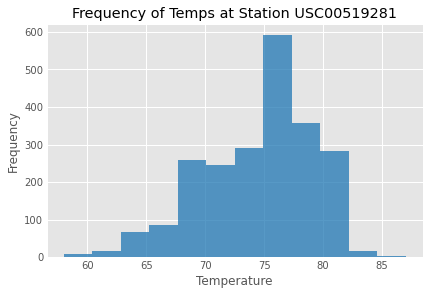

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_count=func.count(measurement.tobs).label('tobs_count')

tobs_activity=session.query(measurement.station, tobs_count)\
.group_by(measurement.station).order_by(tobs_count.desc()).all()

d={'Station':[],'# of Temps':[]}
for i in tobs_activity:
    d['Station'].append(i.station)
    d['# of Temps'].append(i.tobs_count)

tobs_df=pd.DataFrame(d)
dfi.export(tobs_df,'img/station_count.png')

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(measurement.date,measurement.station)\
.filter(measurement.station=='USC00519281').all()

for i in last_date:
    date_time_obj = dt.date.fromisoformat(i.date)

year_ago =  dt.date(date_time_obj.year,date_time_obj.month,date_time_obj.day) - dt.timedelta(days=365)

# Perform a query to retrieve the temperature data
tobs=session.query(measurement.date,measurement.station,measurement.tobs)\
.filter(measurement.date > str(year_ago))\
.filter(measurement.station=='USC00519281').all()

d={'Date':[],'Temperature':[]}
for i in prcp:
    d['Date'].append(i.date)
    d['Temperature'].append(i.tobs)

temp_df=pd.DataFrame(d)

# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('ggplot')
temp_df.hist(column='Temperature',bins=12, color='tab:blue',alpha=0.75)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title("Frequency of Temps at Station USC00519281")
plt.savefig('img/temps.png',bbox_inches='tight')


## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):    
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    temp_min=func.min(measurement.tobs).label('temp_min')
    temp_max=func.max(measurement.tobs).label('temp_max')
    temp_mean=func.avg(measurement.tobs).label('temp_mean')
    
    return session.query(temp_min, temp_mean, temp_max)\
    .filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

results=calc_temps('2011-02-28', '2011-03-05')

d={'tmin':[],'tavg':[],'tmax':[]}
for row in results:
    d['tmin'].append(row.temp_min)
    d['tavg'].append(row.temp_mean)
    d['tmax'].append(row.temp_max)

df=pd.DataFrame(d)
df

,tmin,tavg,tmax
0,61.0,69.755102,75.0


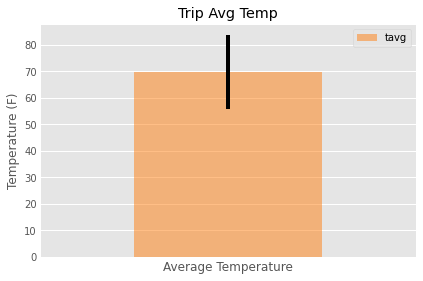

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error=d['tmax'][0]-d['tmin'][0]
plt.style.use('ggplot')
df.plot.bar(y='tavg',yerr=error, align='center', color='tab:orange', alpha=0.5, ecolor='black', capsize=0)
plt.title("Trip Avg Temp")
plt.xlabel('Average Temperature')
plt.xticks([])
plt.ylabel('Temperature (F)')
plt.savefig('img/trip_avg_temp.png',bbox_inches='tight')


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_id=measurement.station.label('Station ID')
prcp_sum=func.sum(measurement.prcp).label('Total Precipitation')
name=station.name.label('Station Name')
lat=station.latitude.label('Latitude')
lng=station.longitude.label('Longitude')
elev=station.elevation.label('Elevation')
start_date='2011-02-28'
end_date='2011-03-05'
                  
sel=[station_id,prcp_sum,name,lat,lng,elev]

results=session.query(*sel).filter(measurement.station == station.station)\
.filter(measurement.date >= start_date).filter(measurement.date <= end_date)\
.group_by(station_id).order_by(prcp_sum.desc()).all()

df=pd.DataFrame(results)
dfi.export(df,'img/total_prcp.png')
df

,Station ID,Total Precipitation,Station Name,Latitude,Longitude,Elevation
0,USC00518838,2.33,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
1,USC00519281,2.23,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00519523,2.19,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,USC00514830,1.96,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00516128,1.45,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
5,USC00513117,1.44,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
6,USC00519397,1.38,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
7,USC00511918,0.63,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00517948,NaN,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip
start_date='2011-02-28'
end_date='2011-03-05'

# Use the start and end date to create a range of dates
date_list=pd.date_range(start_date,end_date)

# Strip off the year and save a list of %m-%d strings
day_month=date_list.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in day_month:
    normals.append(daily_normals(day))

normals

[[(65.0, 70.65517241379311, 80.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)]]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
new_list=[normals[0][0],normals[1][0],normals[2][0],normals[3][0],normals[4][0],normals[5][0]]
new_frame=pd.DataFrame(new_list,columns=['Low Temp (F)','Avg Temp(F)', 'High Temp(F)'])
new_frame['Date']=date_list
new_frame=new_frame.set_index('Date')
dfi.export(new_frame,'img/daily_normals.png')
new_frame

,Low Temp (F),Avg Temp(F),High Temp(F)
Date,,,
2011-02-28,65.0,70.655172,80.0
2011-03-01,64.0,70.032787,76.0
2011-03-02,61.0,70.366667,78.0
2011-03-03,60.0,70.068966,78.0
2011-03-04,57.0,69.272727,77.0
2011-03-05,60.0,67.890909,76.0


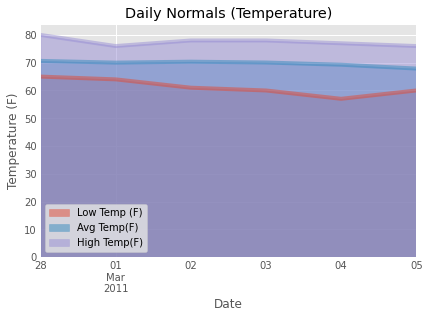

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
plt.style.use('ggplot')
new_frame.plot.area(stacked=False)
plt.title("Daily Normals (Temperature)")
plt.ylabel('Temperature (F)')
plt.savefig('img/plot_daily_normals.png',bbox_inches='tight')

## T-Test (June-Dec)

Using a paired t-test to compare average temperatures across all stations for June versus December. We use a paired t-test because this scenario is reflective of repeated sampling across the same units (stations).

In [24]:
sel = [measurement.tobs]

june=session.query(*sel).filter(func.strftime("%m", measurement.date) == '06').limit(1500).all()
december=session.query(*sel).filter(func.strftime("%m", measurement.date) == '12').limit(1500).all()

test=stats.ttest_rel(june, december, axis=0, nan_policy='propagate', alternative='two-sided')
print(test)

Ttest_relResult(statistic=array([34.69833029]), pvalue=array([3.86409897e-194]))


# Calculate Daily Normals for Precipitation

In [25]:
def daily_precip(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.prcp), func.avg(measurement.prcp), func.max(measurement.prcp)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_precip("01-01")

[(0.0, 0.07479999999999998, 0.42)]

In [26]:
normals=[]
# Set the start and end date of the trip
start_date='2011-02-28'
end_date='2011-03-05'

# Use the start and end date to create a range of dates
date_list=pd.date_range(start_date,end_date)

# Strip off the year and save a list of %m-%d strings
day_month=date_list.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in day_month:
    normals.append(daily_precip(day))

normals

[[(0.0, 0.07903846153846153, 1.08)],
 [(0.0, 0.2939285714285714, 2.4)],
 [(0.0, 0.1842592592592592, 1.88)],
 [(0.0, 0.2207407407407407, 4.68)],
 [(0.0, 0.3320754716981132, 2.7)],
 [(0.0, 0.6449019607843136, 6.24)]]

In [27]:
new_list=[normals[0][0],normals[1][0],normals[2][0],normals[3][0],normals[4][0],normals[5][0]]
new_frame=pd.DataFrame(new_list,columns=['Low (in)','Avg (in)', 'High (in)'])
new_frame['Date']=date_list
new_frame=new_frame.set_index('Date')
dfi.export(new_frame,'img/daily_prcp_nmls.png')
new_frame

,Low (in),Avg (in),High (in)
Date,,,
2011-02-28,0.0,0.079038,1.08
2011-03-01,0.0,0.293929,2.40
2011-03-02,0.0,0.184259,1.88
2011-03-03,0.0,0.220741,4.68
2011-03-04,0.0,0.332075,2.70
2011-03-05,0.0,0.644902,6.24


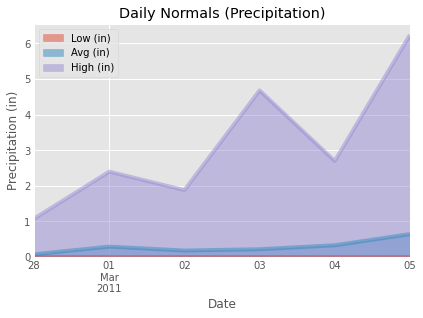

In [28]:
plt.style.use('ggplot')
new_frame.plot.area(stacked=False)
plt.title("Daily Normals (Precipitation)")
plt.ylabel('Precipitation (in)')
plt.savefig('img/plot_daily_prcp_nmls.png',bbox_inches='tight')